# Arm Navigation with Obstacle Avoidance

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MMiknich/MoneyPulator/blob/main/Manipulator.ipynb)

In this notebook we implement basic A* algoritm with heuristic search for planar n-joint manipulator arm.


In [1]:
import copy
import math
import matplotlib.pyplot as plt
import numpy as np
from heapq import heappop, heappush, heapify
from random import randint
import time
from collections.abc import Iterable
from IPython.display import HTML
from PIL import Image, ImageDraw, ImageOps
from IPython.display import Image as Img
from IPython.display import display
from sys import float_info
from matplotlib.animation import FuncAnimation 
EPS = float_info.epsilon
%matplotlib inline

### Environment representation 

Env class represents the environment for our moving agent

- obstacles -- list of stationary obstacles
- root -- connection point of manipulator
- link_len -- length of every segment of manipulator
- link_num -- number of manipulator segments
- state -- initial state (angles) of manipulator
- delta -- angle step for each manipulator oint
- neighbors_moves -- matrix of all possible angle increments
- bounds -- boundaries of environment

> Indented block



In [2]:
class Obstacle:

    '''
    Obstacle class represents simple circle obstacle
    '''
    def __init__(self, coords, r):
        self._center = np.array(coords)
        self._radius = r
    
    def center(self, timestamp=None):
        if timestamp is not None:
            return self._center[timestamp]
        else:
            return self._center

    def radius(self, timestamp=None):
        if timestamp is not None:
            return self._radius[timestamp]
        else:
            return self._radius

In [3]:
class Env:
    '''
    Env represents 2d manipulator enviroment with circle obsticles and gives interface to use it 
    '''
    
    def __init__(self, obstacles = None, manipulator_root = None, manipulator_links = None,
     manipulator_initial_state=None, delta_alpha = 0.1, bounds = [[0, 0], [10, 10]]):
        '''
        Enviroment initialization
        '''
        self.obstacles = obstacles
        self.root = np.array(manipulator_root)
        self.link_len = np.array(manipulator_links)
        self.state = np.array(manipulator_initial_state)
        self.link_num = len(manipulator_links)
        if manipulator_initial_state and manipulator_links:
            # Links number == number of initial angles
            assert(len(manipulator_initial_state) == self.link_num)

        if isinstance(delta_alpha, Iterable):
            assert(len(delta_alpha) == self.link_num)
            self.delta = delta_alpha
        else:
            self.delta = np.array([delta_alpha]*self.link_num)

        self.neighbors_moves = np.stack([self.delta]*3).T * np.array([[-1, 0, 1]]*self.link_num)

        self.bounds = np.array(bounds)

    def __get_links__(self, angles):

        # Links number == number of angles
        assert(len(angles) == len(self.link_len))

        points = [self.root]
        absolute_angle = 0

        for link_len, relative_angle in zip(self.link_len, angles):
            absolute_angle += relative_angle
            new_point = points[-1] + np.array([link_len*np.cos(absolute_angle), link_len*np.sin(absolute_angle)])
            points.append(new_point)

        return [(points[i-1], points[i]) for i in range(1, len(points))]
        
    def __detect_collision__(self, link, obstacle, timestamp = None):
        '''
        Determines whether a line segment (arm link) is in contact
        with a circle (obstacle).
        '''
        a_vec = np.array([link[0][0], link[0][1]])
        b_vec = np.array([link[1][0], link[1][1]])

        link_vec = b_vec - a_vec

        link_norm = np.linalg.norm(link_vec)

        circle_vec = obstacle.center(timestamp) - a_vec
        proj = circle_vec @ (link_vec / link_norm)

        if proj <= 0:
            closest_point = a_vec
        elif proj >= link_norm:
            closest_point = b_vec
        else:
            closest_point = a_vec + link_vec * proj / link_norm


        if np.linalg.norm(closest_point - obstacle.center(timestamp)) > obstacle.radius(timestamp):
            return False
        return True

    def __not_in_bounds__(self, link):
        if np.sum(link < self.bounds[0]) > 0:
            return True
        if np.sum(link > self.bounds[1]) > 0:
            return True
        return False
        
    def traversable(self, angles, timestamp=None):

        for link in self.__get_links__(angles):
            for obstacle in self.obstacles:
                if self.__detect_collision__(link, obstacle, timestamp) or self.__not_in_bounds__(link) :
                    return False 
        return True


    def get_neighbors(self, angles, timestamp = None):
        '''
        Returns a list of neighbouring states to states defined by angles
        '''

        neighbors = []
        delta = np.array(np.meshgrid(*self.neighbors_moves)).T.reshape(-1, self.link_num)
        neighbors_angles = delta + np.array([angles]*delta.shape[0])

        for n_angles in neighbors_angles:
            if self.traversable(n_angles):
                neighbors.append(n_angles)  
        return neighbors

    def plot_arm(self, path, target, filename="output", fps= 5):  # pragma: no cover
        fig = plt.figure(figsize = (self.bounds[1][0] - self.bounds[0][0], self.bounds[1][1] - self.bounds[0][1])) 

        # marking the x-axis and y-axis
        axis = plt.axes(xlim =[self.bounds[0][0],self.bounds[1][0]], 
                        ylim =[self.bounds[0][1],self.bounds[1][1]]) 

        # initializing a line variable
        points = [axis.scatter(target[0], target[1],  color='red')]
        lines = [axis.plot([], [],  color='green', marker='o',
                linewidth=10//(i+1), markersize=9//(i+1))[0] for i in range(self.link_num)]
        circles = [plt.Circle(obstacle.center(), radius=obstacle.radius(), fc='k') for obstacle in self.obstacles]

        def init(): 
            for j, link in enumerate(self.__get_links__(self.state)):
                lines[j].set_data([link[0][0], link[1][0]], [link[0][1], link[1][1]])
            for patch in circles:
                axis.add_patch(patch)
            return lines + circles + points

        def animate(i):
            curr_node = path[i]
            for j,link in enumerate(self.__get_links__(curr_node.angles)):
                lines[j].set_data([link[0][0], link[1][0]], [link[0][1], link[1][1]])

            return lines + circles + points

        anim = FuncAnimation(fig, animate, init_func = init,
                     frames = len(path), interval = 1, blit = True)
        anim.save(filename + '.gif', 
          writer = 'pillow', fps = fps)

### Cost functions

Computes the cost of a transition from `angles1` state to `angles2` state.

The default cost function that represents the elapsed time (number of moves) 

In [4]:
def compute_cost(angles1, angles2, delta):
    '''
    Computes cost of simple moves between cells
    '''
    d = max(abs(angles1 - angles2))
    if abs(d - delta[0]) < EPS:
        return 1
    elif d < EPS:
        return 1
    else:
        print(angles1 - angles2)
        raise Exception('Trying to compute the cost of non-supported move!')


Cost function that represents energy consumption (each angle change costs)

In [5]:
def compute_cost_energy(angles1, angles2, delta):
    '''
    Computes cost of simple moves between cells
    '''
    d = np.sum(abs(angles1 - angles2)) // delta[0]
    return d
    

### Search Node

Search node is the core concept for any (heuristic) search algorithm. It ties together and encapsulates data both about the state of the problem at hand (in the considered case state = the position of manipulator in the space) and data needed to conduct the search (g-, h, f-values etc.)


In [6]:
from re import A
class Node:
    '''
    Node class represents a search node

    - angles: set of manipulator angles, that represents it's state
    - g: g-value of the node (also equals time moment when the agent reaches the cell)
    - h: h-value of the node // always 0 for Dijkstra
    - f: f-value of the node // always equal to g-value for Dijkstra
    - parent: pointer to the parent-node  
    '''
    

    def __init__(self, angles, g = 0, h = 0, f = None, parent = None, deltas = None, init_angles = None):
        self.angles = np.array(angles)
        self.g = g
        self.h = h
        if f is None:
            self.f = self.g + h
        else:
            self.f = f        
        self.parent = parent
        self.deltas = deltas
        self.init_angles = init_angles

    def __eq__(self, other):
        '''
        Estimating where the two search nodes are the same,
        which is needed to detect dublicates in the search tree.
        '''
        
        return max(abs(self.angles - other.angles)) < EPS
    
    def __hash__(self):
        '''
        To implement CLOSED as set of nodes we need Node to be hashable.
        '''
        a = ((self.angles - self.init_angles) // self.deltas).astype(int)
        
        return hash(tuple(a.tolist()))

    

    def __lt__(self, other): 
        '''
        Comparison between self and other. Returns is self < other (self has higher priority).
        '''
        
        return (self.f < other.f) or ((abs(self.f - other.f) < EPS) and (self.g > other.g)) 

### Implementing the search tree (i.e. OPEN and CLOSED)

Efficient implementation of the search tree (OPEN and CLOSED) is crucial for any search algorithm.

In [7]:
import heapq as hq

class SearchTree: #Non list-based implementation of the search tree
    
    def __init__(self):
        self._open = []          # list for the OPEN nodes
        self._closed = set()       # list for the expanded nodes = CLOSED
        self._enc_open_dublicates = 0
        
    def __len__(self):
        return len(self._open) + len(self._closed)
                    
    '''
    open_is_empty should inform whether the OPEN is exhausted or not.
    In the former case the search main loop should be interrupted.
    '''
    def open_is_empty(self):
        return len(self._open) == 0
    
    '''
    Adding a (previously not expanded) node to the search-tree (i.e. to OPEN).
    It's either a totally new node (the one we never encountered before)
    or it can be a dublicate of the node that currently resides in OPEN.
    It's up to us how to handle dublicates in OPEN. We can either 
    detect dublicates upon adding (i.e. inside this method) or detect them
    lazily, when we are extracting a node for further expansion.
    Not detecting dublicates at all may work in certain setups but let's not
    consider this option.
    '''    
    def add_to_open(self, item):
        hq.heappush(self._open, item)
        return    
    
    
    '''
    Extracting the best node (i.e. the one with the minimal key 
    = min f-value = min g-value (for Dijkstra)) from OPEN.
    This node will be expanded further on in the main loop of the search.
    ''' 
    def get_best_node_from_open(self):
        
        best_node = hq.heappop(self._open)
        while self.was_expanded(best_node):
            if not self._open:
                return None
            best_node = hq.heappop(self._open)
            self._enc_open_dublicates +=1
        return best_node

    def add_to_closed(self, item):
        self._closed.add(item)

    def was_expanded(self, item):
        return item in self._closed

    @property
    def OPEN(self):
        return self._open
    
    @property
    def CLOSED(self):
        return self._closed

    @property
    def number_of_open_dublicates(self):
        return self._enc_open_dublicates  

## A* Algorithm


The first (main) ingridient of the `A*` algorithm is the heuristic function.

Ideally, it should be admissible (never overestimate the true cost to the goal) and consistent (~satisfy triangle inequality).

In [8]:
# Functions for heuristics
def manhattan_distance(i1, j1, i2, j2):
    return abs(j2 - j1) + abs(i2 - i1)

def euclidean_distance(i1, j1, i2, j2):
    return ((j2 - j1)**2 + (i2 - i1)**2)**0.5

In [9]:
def astar(grid_map, start_angles, goal_i, goal_j, heuristic_func = None, search_tree = None, cost_func = None):

    ast = search_tree()
    steps = 1
    nodes_created = 0
    
    h_fun = lambda i, j:  heuristic_func(i, j, goal_i, goal_j) #for shortening the code
    
    # goal_node = Node(goal_i, goal_j, g = np.inf)    
    
    effector = grid_map.__get_links__(start_angles)[-1][1]

    start_node = Node(start_angles, g=0, h=h_fun(effector[0], effector[1]), deltas = grid_map.delta, init_angles = start_angles)
    
    nodes_created = 1
    
    ast.add_to_open(start_node)
    
    while ast._open:
        
        working_node = ast.get_best_node_from_open()
        effector = grid_map.__get_links__(working_node.angles)[-1][1]

        # print('Neig: ', (working_node.angles - start_angles) // grid_map.delta[0])

        if euclidean_distance(effector[0], effector[1], goal_i, goal_j) < 1e-1:
            return (True, working_node, steps, nodes_created, set(ast._open), set(ast._closed))
        
        else:
            neighbors = grid_map.get_neighbors(working_node.angles)            

            for neib_angles in neighbors:
                
                new_g = working_node.g + cost_func(working_node.angles, neib_angles, grid_map.delta)
                neib_effector = grid_map.__get_links__(neib_angles)[-1][1]

                h = h_fun(neib_effector[0], neib_effector[1])
                
                new_node = Node(neib_angles, new_g, h, parent=working_node, deltas = grid_map.delta, init_angles = start_angles)
                nodes_created += 1
                if not ast.was_expanded(new_node):
                    ast.add_to_open(new_node)            
            
            ast.add_to_closed(working_node)
            
        steps += 1
    
    return False, None, steps, nodes_created, None, set(ast._closed)

### Validating the results


Restoring the path from the goal state

In [10]:
def make_path(goal):
    '''
    Creates a path by tracing parent pointers from the goal node to the start node
    It also returns path's length.
    '''

    length = goal.g
    current = goal
    path = []
    while current.parent:
        path.append(current)
        current = current.parent
    path.append(current)
    return path[::-1], length

`stationary_test` tests the pathfing algorithm on a single simple instance. Tests assume that the search function fits the following pattern:


`search(task_map, start_angles, goal.i, goal.j, *optional arguments*) -> (path_found, last_state, steps, nodes_created, discovered, expanded)`, where

- `task_map` -- our environment
- `start_angles` -- initial manipulator angles
- `goal.i, goal.j` -- (i,j) coordinates of the goal
- `*optional arguments*` -- additional parameters of the search function, passed with `*args`. E.g. the heuristic function.
- `path_found` -- `True` if path was found, `False` otherwise
- `last_state` -- last state of the path. `None` if path was not found
- `steps` -- the number of search steps
- `nodes_created` -- the number of the nodes, which were created and stored during the search process 
- `open` -- iterable collection of open nodes
- `expanded` --  iterable collection of the expanded nodes
- `re-expanded` -- iterable collection of the re-expanded nodes

In [11]:
def stationary_test(search_func, task, obs_flag, *args):
    '''
    simple_test runs search_func on one task (use a number from 0 to 4 to 
    choose a certain debug task on simple map or None to choose a random task 
    from this pool) with *args as optional arguments and displays:
     - 'Path found!' and some statistics -- path was found
     - 'Path not found!' -- path was not found
     
    Parameters
    ----------
    search_func : function
        Function, which implements the method to run
    task : int
        Number of task from pregenerated set. Must be in the range from 0 to 4 (use None ro run random task)
    '''
    # environment size
    height = 15
    width = 15
    bounds = [[0, 0], [height, width]]

    # angle discrete
    d_theta = 0.05*np.pi

    # manipulator segment lengths and initial angles
    manipulator_ls = [[3., 3.], [2., 2., 2.], [1.5, 1.5, 1.5, 1.5], [6./5, 6./5, 6./5, 6./5, 6./5]]
    manipulator_thetas = [[5/4*np.pi, 0.], [5/4*np.pi, 0., 0.], [5/4*np.pi, 0., 0., 0.], [5/4*np.pi, 0., 0., 0., 0.]]
    
    # manipulator connection point and goal point
    starts = [(height/2, width/2), (height/2, width/2), (height/2, width/2), (height/2, width/2)]
    goals = [(width/2 - 6/2**0.5, height/2 + 6/2**0.5), (width/2 - 6/2**0.5, height/2 + 6/2**0.5), (width/2 - 6/2**0.5, height/2 + 6/2**0.5), (width/2 - 6/2**0.5, height/2 + 6/2**0.5)]
    # print(goals)

    # list of stationary obstacles
    objects = []
    if obs_flag:
        objects.append([height/2-2.25, width/2+5.25, 1.5])
        objects.append([height/2-4.5, width/2+1.5, 1.25])
        objects.append([height/2+3, width/2+0, 1.])
    
    if (task is None) or not (0 <= task < 4):
        task = randint(0, 3)

    for i, obj in enumerate(objects):
        objects[i] = Obstacle(obj[:-1], obj[-1])

    task_map = Env(obstacles=objects,
                   manipulator_root=starts[task],
                   manipulator_links=manipulator_ls[task],
                   manipulator_initial_state=manipulator_thetas[task],
                   delta_alpha=d_theta,
                   bounds=bounds)

    start_angles = manipulator_thetas[task]
    goal = goals[task]

    result = search_func(task_map, start_angles, goal[0], goal[1], *args)
    number_of_steps = result[2]
    nodes_created = result[3]
    if result[0]:
        path, length = make_path(result[1])
        print("Path found! Length: " + str(length) + \
              ". Nodes created: " + str(nodes_created) + \
              ". Number of steps: " + str(number_of_steps))

        task_map.plot_arm(path, goal, filename="file")
    else:
        print("Path not found!")

### Run tests

Tests arguments:

`test(algorithm, test_num, obstacles, *optional arguments*)`, where

- `algorithm` -- path search algorithm
- `test_num` -- test number
- `obstacles` -- obstacles flag (use obstacles or not)
- `*optional arguments*` -- additional parameters of the search function. E.g. the heuristic function.

Path found! Length: 18. Nodes created: 161761. Number of steps: 6357
CPU times: user 1min 32s, sys: 1.14 s, total: 1min 34s
Wall time: 1min 36s


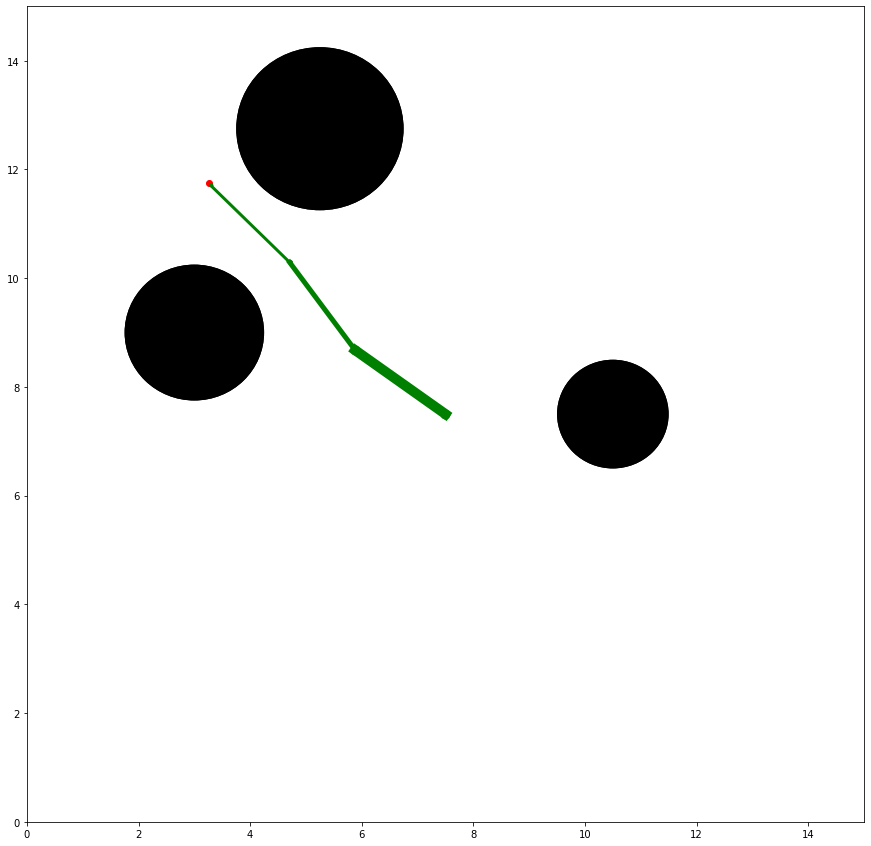

In [12]:
%time stationary_test(astar, 1, True, euclidean_distance, SearchTree, compute_cost)